# Recursive QAOA

In [2]:
import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from openqaoa.qaoa_parameters import QAOACircuitParams, create_qaoa_variational_params, Hamiltonian
from openqaoa.devices import create_device
from openqaoa.backends.qaoa_backend import get_qaoa_backend
from openqaoa.optimizers import get_optimizer
from openqaoa.utilities import *
from openqaoa.workflows.optimizer import QAOA, RQAOA
from openqaoa.problems.problem import QUBO, MaximumCut, MinimumVertexCover

In [3]:
# Set plotting style
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600
#plt.rcParams['font.size'] = '12'
#plt.rc('font', family='serif', size=600)

sns.axes_style("whitegrid")
sns.set_context("paper", font_scale=2.5)

In [4]:
def random_k_regular_graph_normal_distribution(degree: int,
                           nodes: List[int],
                           seed: int = None,
                           weighted: bool = False,
                           sigma: float = 1.0,
                           mu: float = 0.0,
                           biases: bool = False) -> nx.Graph:
    """
    Produces a random graph with specified number of nodes, each having degree k.

    Parameters
    ----------
    degree: `int`
        Desired degree for the nodes.
    nodes: `list`
        The node set of the graph.
    seed: `int`, optional
        A seed for the random number generator.
    weighted: `bool`, optional
        Whether the edge weights should be uniform or different. If false, all weights are set to 1.
        If true, the weight is set to a random number drawn from the uniform distribution in the
        interval 0 to 1.
    biases: `bool`, optional
        Whether or not the graph nodes should be assigned a weight.
        If true, the weight is set to a random number drawn from the uniform
        distribution in the interval 0 to 1.

    Returns
    -------
    nx.Graph: `Networkx Graph`
        A graph with the properties as specified.
    """
    # Set numpy seed
    np.random.seed(seed=seed)

    # Create a random regular graph on the nodes
    G = nx.random_regular_graph(degree, len(nodes), seed)

    # Relabel nodes
    nx.relabel_nodes(G, {i: n for i, n in enumerate(nodes)})

    # Add edges between nodes
    for edge in G.edges():

        # If weighted attribute is False, all weights are set to 1
        if not weighted:
            G[edge[0]][edge[1]]['weight'] = 1

        # If weighted attribute is True, weights are assigned as random integers
        else:
            G[edge[0]][edge[1]]['weight'] = np.random.normal(mu, sigma)

    # If biases attribute is True, add node weights as random integers
    if biases:
        for node in G.nodes():
            G.nodes[node]['weight'] = np.random.rand()

    return G

In [31]:
def run_Rqaoa_experiment(qubo, optimizer, init_beta, init_gamma):    
    # Run QAOA experiment
    # initialize model with default configurations
    q = QAOA()

    # device
    qiskit_device = create_device(location='local', name='qiskit.statevector_simulator')
    vectorized_device = create_device(location='local', name='vectorized')
    q.set_device(vectorized_device)

    # circuit properties
    #q.set_circuit_properties(p=1, param_type='standard', init_type='custom', variational_params_dict={'betas': [init_beta], 'gammas': [init_gamma]}, mixer_hamiltonian='x')
    q.set_circuit_properties(p=1, param_type='standard', init_type='ramp', mixer_hamiltonian='x')

    
    # classical optimizer properties
    q.set_classical_optimizer(method=optimizer, 
                              optimizer_options = {"stepsize" : 0.01},
                              tol=10**(-6), maxfev=6000, maxiter=2000, 
                              jac='finite_difference',
                              #parameter shift
                              hess='finite_difference',
                              optimization_progress=True, 
                              cost_progress=True, parameter_log=True)

    # Define RQAOA instance - We select the type to be custom, set steps to 1 and pass the QAOA instance with all the desired properties
    R = RQAOA(qaoa = q, rqaoa_type = 'custom')

    # Set parameters for RQAOA, in this case we fix the steps to 1 (default), the final cutoff value to 3
    R.set_rqaoa_parameters(steps = 1, n_cutoff = 3)

    # Compile problem instance on RQAOA, just like with QAOA
    R.compile(maxcut_qubo)
    
    R.optimize()
    
    return R.result


In [5]:
# Define problem

n = 12
k = 3
seed = 1
sigma = 0.1
mu = 0.0 

# restricted for udR graphs:
betas = np.linspace(-np.pi/2, np.pi/2, 50)
gammas = np.linspace(-np.pi, np.pi, 50)

# shifted
#betas = np.linspace(0, np.pi/4, 50)
#gammas = np.linspace(0, 6*np.pi, 50)

# Define 3wR graph and plot it
g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=seed, weighted=True, mu=mu, sigma=sigma, biases=False)
#plot_graph(g)
#plt.savefig("graph_sigma={}.png".format(sigma))
#plt.clf()

# Define te problem and translate it into a binary Qubo.
maxcut_prob = MaximumCut(g)
maxcut_qubo = maxcut_prob.get_qubo_problem()

# Define Hamiltonian
cost_hamiltonian = hamiltonian_from_graph(g)



In [6]:
optimizer="cobyla"

# Define the QAOA properties
q = QAOA()

# Set the properties you want - These values are actually the default ones!
q.set_circuit_properties(p=1, param_type='standard', init_type='ramp', mixer_hamiltonian='x')

# Define the device you want to run your problem on using the create_device() function - Here we choose the local wavefunction simulator supported by OpenQAOA
device = create_device(location = 'local', name = 'vectorized')
q.set_device(device)

# Set the classical method used to optimize over QAOA angles and its properties

q.set_classical_optimizer(method=optimizer, 
                              optimizer_options = {"stepsize" : 0.01},
                              tol=10**(-6), maxfev=6000, maxiter=2000, 
                              jac='finite_difference',
                              #parameter shift
                              hess='finite_difference',
                              optimization_progress=True, 
                              cost_progress=True, parameter_log=True)

# Here are other ways in which the above selection can be generalized!

# device = create_device(location = 'qcs',name = 'Aspen-11', as_qvm = True, client_configuraton = qcs_credentials)
# q.set_device(device)
# q.set_backend_properties(n_shots=100, cvar_alpha=1)
# q.set_circuit_properties(param_type = 'extended', init_type = 'fourier_extended')
# q.set_classical_optimizer(method='Nelder-Mead', maxiter=1000)

In [50]:
# Define RQAOA instance - We select the type to be custom, set steps to 1 and pass the QAOA instance with all the desired properties
R = RQAOA(qaoa = q, rqaoa_type = 'custom')

# Set parameters for RQAOA, in this case we fix the steps to 1 (default), the final cutoff value to 3
R.set_rqaoa_parameters(steps = 1, n_cutoff = 3)

# Compile problem instance on RQAOA, just like with QAOA
R.compile(maxcut_qubo, verbose=False)

In [52]:
# Solve problem with RQAOA
R.optimize(verbose=False)

TypeError: optimize() takes 1 positional argument but 2 were given

In [11]:
# Extract results
R.result

{'solution': {'101101110001': -1.52520280502617,
  '010010001110': -1.52520280502617},
 'classical output': {'minimum energy': -0.08114540828449196,
  'optimal states': ['110', '001']},
 'elimination rules': [{(2, 3): 1.0},
  {(3, 7): 1.0},
  {(3, 4): -1.0},
  {(1, 3): 1.0},
  {(0, 1): -1.0},
  {(1, 5): -1.0},
  {(3, 5): 1.0},
  {(1, 3): 1.0},
  {(1, 2): 1.0}],
 'schedule': [1, 1, 1, 1, 1, 1, 1, 1, 1],
 'total steps': 9}

In [23]:
# Solve the problem analytically
energy, configuration = ground_state_hamiltonian(cost_hamiltonian)

optimization_energy = list(R.result['solution'].values())[0]

# Obtain approximation ratio
r = np.abs(optimization_energy) / np.abs(energy)


In [24]:
r

1.0

In [49]:
R.result['intermediate_steps'][i]['QUBO']

KeyError: 'intermediate_steps'

### Averaging

In [38]:
# Define problem

n = 12
k = 3
sigma_list = [0.1, 1, 10, 100]
mu = 5.0 
betas = np.linspace(-np.pi/2, np.pi/2, 50)
gammas = np.linspace(-np.pi, np.pi, 50)


#optimizer_list = ["vgd", "rmsprop", 'newton-cg', 'cobyla', 'nelder-mead', 'powell' ]

optimizer_list = ["rmsprop", 'cobyla']

#seed_list = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]

seed_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

data = []  # list to contain optimization results to be converted into a data frame

for sigma in sigma_list:
    print("Sigma =", sigma)
    
    for seed in seed_list:
        print("Seed =", seed)

        # Define 3wR graph and plot it
        g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=seed, weighted=True, mu=mu, sigma=sigma, biases=False)
        #plot_graph(g)
        #plt.savefig("graph_sigma={}.png".format(sigma))
        #plt.clf()

        # Define te problem and translate it into a binary Qubo.
        maxcut_prob = MaximumCut(g)
        maxcut_qubo = maxcut_prob.get_qubo_problem()

        # Define Hamiltonian
        cost_hamiltonian = hamiltonian_from_graph(g)

        #cost_landscape_std = create_cost_landscape_std(cost_hamiltonian, betas, gammas)
        #plot_landscape(cost_landscape_std, betas, gammas, sigma, mu)


        for optimizer in optimizer_list:
            print("Optimizer =", optimizer)

            # initialize away from the minimum
            init_beta = 0.5
            init_gamma = -0.2

            opt_results = run_Rqaoa_experiment(maxcut_qubo, optimizer, init_beta, init_gamma)

            optimization_energy = list(opt_results['solution'].values())[0]
            
            # Solve the problem analytically
            energy, configuration = ground_state_hamiltonian(cost_hamiltonian)

            # Obtain approximation ratio
            r = np.abs(optimization_energy) / np.abs(energy)
            
            data.append([sigma, optimizer, seed, r])

df = pd.DataFrame(np.array(data), columns=['sigma', 'optimizer', 'seed', 'r'])

df['sigma'] = df['sigma'].astype(float)
df['optimizer'] = df['optimizer'].astype(str)
df['seed'] = df['seed'].astype(int)
df['r'] = df['r'].astype(float)

Sigma = 0.1
Seed = 1
Optimizer = rmsprop
Optimizer = cobyla


/Users/kk/Workspace/OpenQAOA/venv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:687: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Seed = 2
Optimizer = rmsprop
Optimizer = cobyla
Seed = 3
Optimizer = rmsprop
Optimizer = cobyla
Seed = 4
Optimizer = rmsprop
Optimizer = cobyla
Seed = 5
Optimizer = rmsprop
Optimizer = cobyla
Seed = 6
Optimizer = rmsprop
Optimizer = cobyla
Seed = 7
Optimizer = rmsprop
Optimizer = cobyla
Seed = 8
Optimizer = rmsprop
Optimizer = cobyla
Seed = 9
Optimizer = rmsprop
Optimizer = cobyla
Seed = 10
Optimizer = rmsprop
Optimizer = cobyla
Sigma = 1
Seed = 1
Optimizer = rmsprop
Optimizer = cobyla
Seed = 2
Optimizer = rmsprop
Optimizer = cobyla
Seed = 3
Optimizer = rmsprop
Optimizer = cobyla
Seed = 4
Optimizer = rmsprop
Optimizer = cobyla
Seed = 5
Optimizer = rmsprop
Optimizer = cobyla
Seed = 6
Optimizer = rmsprop
Optimizer = cobyla
Seed = 7
Optimizer = rmsprop
Optimizer = cobyla
Seed = 8
Optimizer = rmsprop
Optimizer = cobyla
Seed = 9
Optimizer = rmsprop
Optimizer = cobyla
Seed = 10
Optimizer = rmsprop
Optimizer = cobyla
Sigma = 10
Seed = 1
Optimizer = rmsprop
Optimizer = cobyla
Seed = 2
Optimize

In [39]:
df

,sigma,optimizer,seed,r
0,0.1,rmsprop,1,0.711891
1,0.1,cobyla,1,1.000000
2,0.1,rmsprop,2,1.000000
3,0.1,cobyla,2,1.000000
4,0.1,rmsprop,3,0.712549
...,...,...,...,...
75,100.0,cobyla,8,0.957863
76,100.0,rmsprop,9,0.954289
77,100.0,cobyla,9,1.000000
78,100.0,rmsprop,10,1.000000


In [43]:
df.to_csv("data_17.11_RQAOA_seeds.csv")

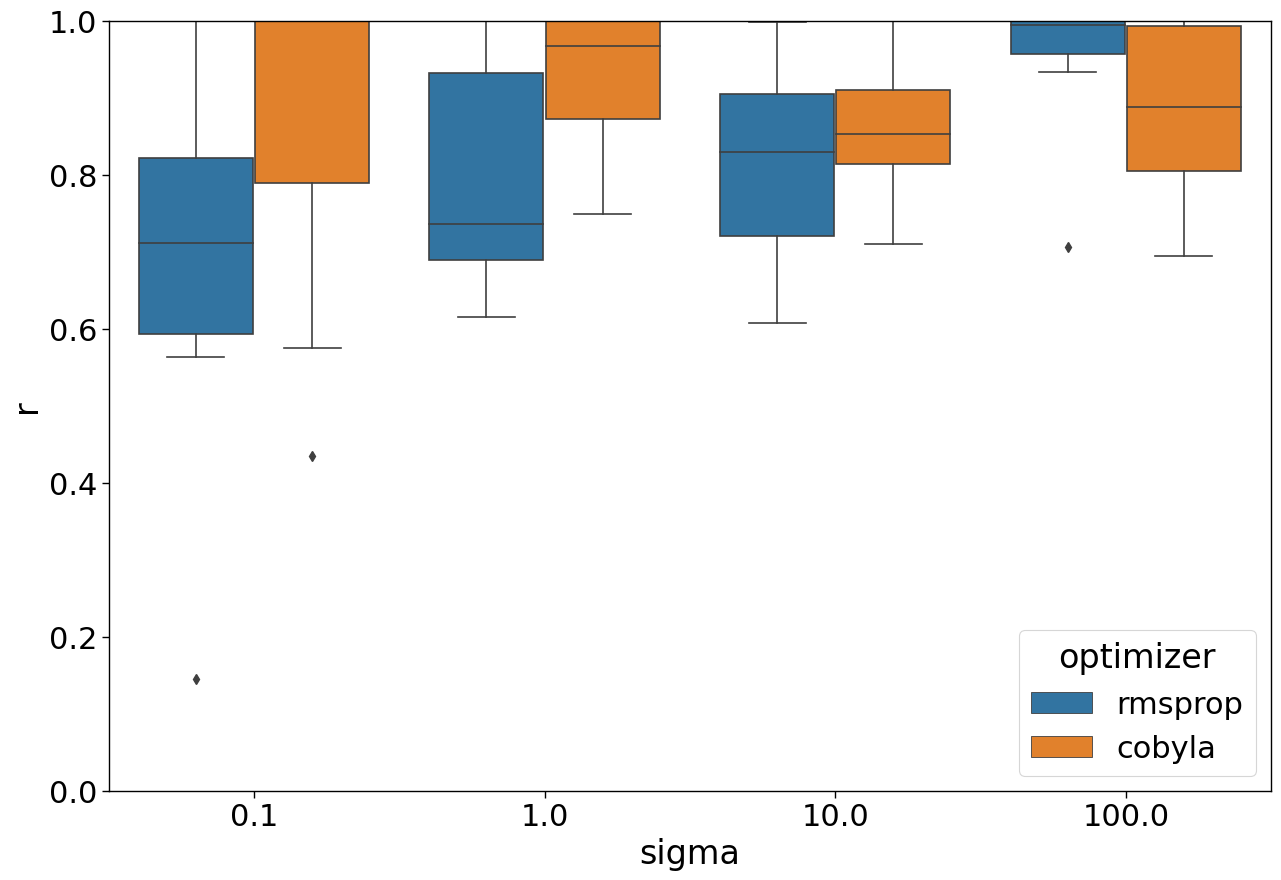

In [45]:
#plt.xscale('log')
plt.ylim(0, 1)
box_plot = sns.boxplot(data = df, x = 'sigma', y ='r', hue="optimizer")

plt.savefig("Approximation_ratio_mu=5.0_RQAOA_ramp.png")
